In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'MIT Download')

In [3]:
print(len(messages))

28


In [102]:
import base64
import re
from tqdm import tqdm
import pandas as pd

def parse_must_reads(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    must_reads = msg_body[msg_body.index('The must-reads'):]
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE)
    articles = []
    for i in range(1, 11):
        try:
            articles.append(list(re.findall('\n' + str(i) + ' (.*)\r\n(.*) \((.*) \r\n', text, re.MULTILINE)[0]))
        except:
            try:
                articles.append(list(re.findall('\n' + str(i) + ' (.*)\r\n(.*)\((.*) \r\n', text, re.MULTILINE)[0]))
            except:
                continue
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    if msg_body.find('The must-reads') != -1:
        fetched_articles = parse_must_reads(date, msg_body)
        for must_reads in fetched_articles:
            data.append([date, *must_reads])
    else:
        continue


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


In [103]:
print(len(data))
print(data[0])

239
[Timestamp('2021-08-13 12:04:06+0000', tz='UTC'), 'The FDA approved third covid shots for immunocompromised people', "Some people, such as cancer or HIV patients, don't seem to produce a sufficient immune response after two doses.", 'CNBC']


In [104]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Source'])
df.to_csv('must_reads_MIT_download.csv', index=False)
df

,Date,Title,Subtitle,Source
0,2021-08-13 12:04:06+00:00,The FDA approved third covid shots for immunoc...,"Some people, such as cancer or HIV patients, d...",CNBC
1,2021-08-13 12:04:06+00:00,New research suggests hydrogen may be pretty b...,"It's seen as the clean energy of the future, b...",NYT
2,2021-08-13 12:04:06+00:00,Incels keep trying to take over Reddit's large...,The moderators keeping this nonsense at bay de...,Mel
3,2021-08-13 12:04:06+00:00,Inside Substack's risky global expansion,It's going to have to grapple with threats to ...,Rest of World
4,2021-08-13 12:04:06+00:00,China's tech industry has a huge sexism problem,A rape allegation at Alibaba has shone a spotl...,NYT
...,...,...,...,...
234,2021-07-12 12:07:58+00:00,How a ransomware attack works,"This breaks the anatomy of these hacks down, s...",WP
235,2021-07-12 12:07:58+00:00,Amazon is pulling brands from its store—and co...,There has to be a better way of dealing with i...,The Verge
236,2021-07-12 12:07:58+00:00,How to make working remotely work,"Out with surveillance and visible busyness, in...",New Yorker
237,2021-07-12 12:07:58+00:00,In defense of Twitter,"Yes, it can be awful. But it can be wonderful,...",FT


<AxesSubplot:>

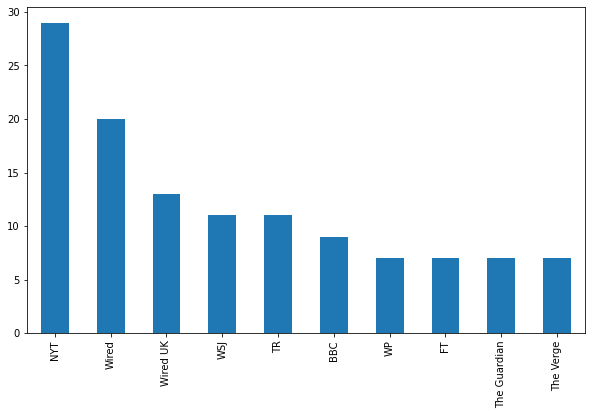

In [105]:
df['Source'].value_counts().iloc[:10].plot.bar(figsize=(10,6))

In [125]:
df['combined'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df['combined'].iloc[0]

"The FDA approved third covid shots for immunocompromised people Some people, such as cancer or HIV patients, don't seem to produce a sufficient immune response after two doses."

In [126]:
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
df['combined'] = df['combined'].str.replace('  ', ' ')
df

,Date,Title,Subtitle,Source,combined
0,2021-08-13 12:04:06+00:00,The FDA approved third covid shots for immunoc...,"Some people, such as cancer or HIV patients, d...",CNBC,The FDA approved third covid shots for immunoc...
1,2021-08-13 12:04:06+00:00,New research suggests hydrogen may be pretty b...,"It's seen as the clean energy of the future, b...",NYT,New research suggests hydrogen may be pretty b...
2,2021-08-13 12:04:06+00:00,Incels keep trying to take over Reddit's large...,The moderators keeping this nonsense at bay de...,Mel,Incels keep trying to take over Reddit's large...
3,2021-08-13 12:04:06+00:00,Inside Substack's risky global expansion,It's going to have to grapple with threats to ...,Rest of World,Inside Substack's risky global expansion It's ...
4,2021-08-13 12:04:06+00:00,China's tech industry has a huge sexism problem,A rape allegation at Alibaba has shone a spotl...,NYT,China's tech industry has a huge sexism proble...
...,...,...,...,...,...
234,2021-07-12 12:07:58+00:00,How a ransomware attack works,"This breaks the anatomy of these hacks down, s...",WP,How a ransomware attack works This breaks the ...
235,2021-07-12 12:07:58+00:00,Amazon is pulling brands from its storeand con...,There has to be a better way of dealing with i...,The Verge,Amazon is pulling brands from its storeand con...
236,2021-07-12 12:07:58+00:00,How to make working remotely work,"Out with surveillance and visible busyness, in...",New Yorker,How to make working remotely work Out with sur...
237,2021-07-12 12:07:58+00:00,In defense of Twitter,"Yes, it can be awful. But it can be wonderful,...",FT,"In defense of Twitter Yes, it can be awful. Bu..."


(-0.5, 2999.5, 1999.5, -0.5)

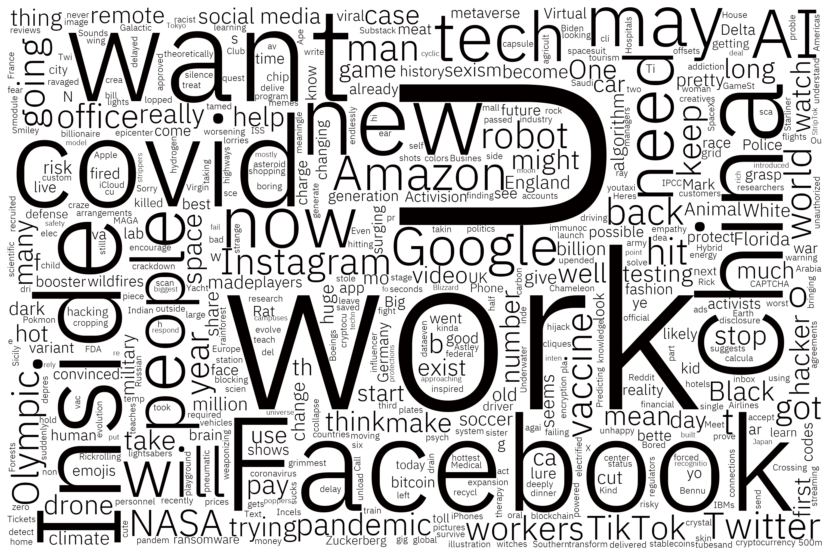

In [133]:
import matplotlib.pyplot as plt
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Light.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500).generate_from_text(df['combined'].to_string())
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")